In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

## Loading and Reviewing the Data

In [3]:
# reading the dataset
df = pd.read_csv("public/data_source/rca_dataset.csv")
#df = pd.read_csv("public/data_source/Crime_Data_from_2020_to_Present.csv")
faultsDataFrame = pd.read_csv("public/data_source/ret_info.csv")

##### Change "succ" from boolean to integer, True=1, False=0

In [4]:
succ_map = {True : 1, False : 0}
df['succ'] = df['succ'].map(succ_map)

In [5]:
import datetime

df['timestamp'] = df['timestamp'].apply(lambda d: datetime.datetime.fromtimestamp(int(d) / 1000))
timestamp_ = df['timestamp']
#.strftime('%Y-%m-%d %H:%M:%S'))


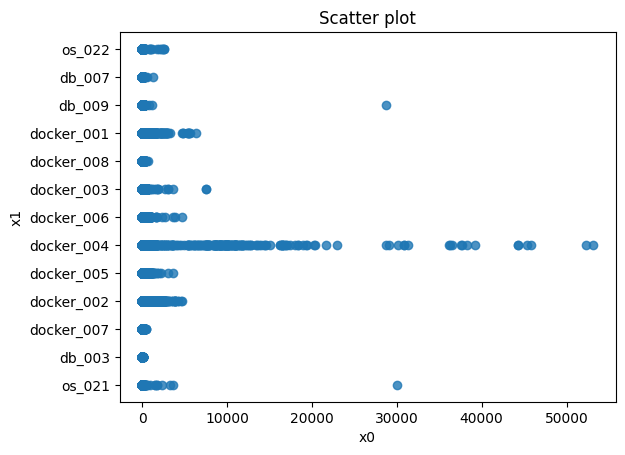

In [7]:
# Plot variables latency and target in a scatter plot
#df.plot.scatter('latency', 'target')
plt.scatter(df.iloc[:, 2], df.iloc[:, 5], alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [8]:
df.head(5)

,trace_id,timestamp,latency,succ,source,target
0,2798717183c0df0e9932,2020-04-21 17:26:40,0,0,os_021,os_021
1,2798717183c0df0e9932,2020-04-21 17:26:40,101,0,None,os_021
2,0af4f17183c0f7fd6282,2020-04-21 17:26:40,0,0,os_021,os_021
3,0af4f17183c0f7fd6282,2020-04-21 17:26:40,11,0,None,os_021
4,f0f9617183c0fa9f6112,2020-04-21 17:26:40,0,0,os_021,os_021


##### Converting "target" to Int

In [6]:
le = preprocessing.LabelEncoder()
le.fit(df['target'])
LabelEncoder()
list(le.classes_)
targetTransformed = le.transform(df['target'])

##### Concatenate features that will be used (latency and target)

In [7]:
X1 = df['latency'].values.reshape(-1,1)
X2 = targetTransformed.reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)

#### Algorithms

In [8]:
outliers_fraction = 0.2
# Test 4 different methods
classifiers = {
        #'FeatureBagging': FeatureBagging(contamination=outliers_fraction),
        'KNN': KNN(contamination=outliers_fraction),
        #'HBOS': HBOS(contamination=outliers_fraction),
        #'IForest': IForest(contamination=outliers_fraction)
}

In [13]:
def getConfusionMatrix(actual, predicted):
    import datetime
    
    truePositive = []
    trueNegative = []
    falsePositive = []
    falseNegative = []
    #predicted = predicted.assign(date_time = list(map( lambda x: datetime.fromtimestamp(x/1000), predicted.timestamp)))
    predicted = predicted.assign(date_time = lambda x: df['timestamp'])
    #date_time = datetime.datetime.strptime(date_time,'%Y-%m-%d %H:%M:%S+08:00')
    # 
    # 
    for i, act in actual.iterrows(): 
         
         minTime = datetime.datetime.strptime(act.time_preliminary,'%Y-%m-%d %H:%M:%S+08:00') + timedelta(hours=15)
         maxTime = minTime + timedelta(minutes=5)
         
         truePositive.append(predicted.loc[(predicted.date_time  >= minTime) & (predicted.outliers == 1) & (predicted.target == act.ground_truth)])
         # & (predicted.date_time <= maxTime)
         trueNegative.append(predicted.loc[(predicted.date_time < minTime) & (predicted.date_time > maxTime) & (predicted.outliers == 0)])
         falsePositive.append(predicted.loc[(predicted.date_time < minTime) | (predicted.date_time > maxTime) & (predicted.outliers == 1)])
         falseNegative.append(predicted.loc[(predicted.date_time >= minTime) & (predicted.outliers == 0) & (predicted.target == act.ground_truth)])
         #| (predicted.date_time > maxTime)

         del maxTime, minTime

    else: #remove all empty row
     truePositive = list(filter(lambda dfTP: not dfTP.empty, truePositive))
     trueNegative = list(filter(lambda dfTN: not dfTN.empty, trueNegative))
     falsePositive = list(filter(lambda dfFP: not dfFP.empty, falsePositive))
     falseNegative = list(filter(lambda dfFN: not dfFN.empty, falseNegative))

     print("True Positive: ", len(truePositive))
     print("True Negative: ", len(trueNegative))
     print("False Positive: ", len(falsePositive))
     print("False Negative: ", len(falseNegative))

     """
        count = 0
        for i, *trueP in truePositive:
             count = count + len(trueP)
        print("True Positive: ", count)

        count = 0
        for i, *trueN in trueNegative:
             count = count + len(trueN)
        print("True Negative: ", count)

        count = 0
        for i, *falseP in falsePositive:
             count = count + len(falseP)
        print("False Positive: ", count)

        count = 0
        for i, *falseN in falseNegative:
             count = count + len(falseN)
        print("False Negative: ", count) 

    return (truePositive, falsePositive, trueNegative, falseNegative)   

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 40)

## Implementation

In [ ]:
#xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 401244))
#plt.figure(figsize=(10, 10))

for i, (clf_name, clf) in enumerate(classifiers.items()):

    # Training the model  
    clf.fit(X)

    #  Predicting raw outlier scores
    y_pred = clf.predict(X)

    #  Predict if a particular sample is an outlier or not
    scores_pred = clf.decision_function(X) * -1

    np.unique(y_pred, return_counts=True)

    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)

    outliers = np.where(y_pred == 1)
    #outliersList = df.iloc[outliers[0], :]

    print('\n\nOUTLIERS: ', n_outliers, 'INLIERS: ', n_inliers, clf_name)
    # print(outliersList.head(5))

    predicted = df.assign(outliers=y_pred)

    getConfusionMatrix(faultsDataFrame, predicted)
    #print(predicted.head(5))

